## Quick Guide


The notebook works as a simple script that calls data from CDMNext using CEIC's Python package, extracts all series from the selected insight, gets all timepoints for these series, builds dataframe, and create a grid of interactive plots with the given dataframes


> #### Installation Guide
>
> 1. Install Python 3.9+
> 2. Open terminal and execute
>  - pip install --extra-index-url https://downloads.ceicdata.com/python ceic_api_client
>  - pip install --extra-index-url https://downloads.ceicdata.com/python ceic_api_client --upgrade
---

> #### Usage Guide
>
> **Import libraries** - cell to define libraries we need to set before running the code<br />
> **Insight Information** - cell to define the insight we want to replicate<br />
> **Function Definitions** - to read or change the existing logic used by the main program<br />
> **DataFrames** - select the dataframes that are going to be plotted<br />
> **Code Execution** - run the main program based on parameters and functions<br />
> 
>
> Visit **[CEIC Main Page](https://www.ceicdata.com/en)** for more information on how to use our data and the PyCEIC package.
>

### Import Libraries

In [1]:
# Call the PyCEIC functionalities 
from ceic_api_client.pyceic import Ceic 
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.patches import Patch
import matplotlib.image as image
import matplotlib.image as mpimg
from pylab import *
import openpyxl
import numpy as np
import pandas as pd
import math

# Libraries nedded to include interactive widgets
from IPython.display import clear_output
from datetime import datetime

In [2]:
workbook = openpyxl.load_workbook(r'C:\Users\necheverry\OneDrive - Internet Securities, LLC\Documents\Documentos\CEIC\Scripts\Python\credentials.xlsx')
sheet = workbook.active
user = sheet['A2'].value
pasw = sheet['B2'].value
Ceic.login(user,pasw)

C:\Users\necheverry\Anaconda3\lib\site-packages\ceic_api_client\facade\pyceic_warnings.py:83: UserWarning: 
interaction interface to CEIC macroeconomic data and
any data usage abuse attempt will be recorded.
  warnings.warn(message=self._WARNING_MESSAGE, category=UserWarning)


### Insight information

United States Inflation Nowcast
  <br>
id: 'f645159d-f17c-4917-a97a-966172f849eb'  <br>
Link: https://insights.ceicdata.com/United-States-Inflation-Nowcast

In [3]:
def get_series_to_df(id_insight):
    
    '''This function takes the id of an insight as an 
    argument and downloads the series associated with the insight. 
    After that the series are stored in a DataFrame depending 
    on the frequency(daily,weeklr or monthly).'''
    
    series_d, series_w, series_m = {},{},{} # Dictionaries for each type of frequencies
    
    # Download the insight series
    result = Ceic.insight_series(id_insight)
    
    #
    for s in result.data.items:
        if s.series_data != None:
            if s.insight_series.applied_functions != None:
                column = s.series_data.metadata.name + ': ' + s.insight_series.applied_functions
            else:
                column = s.series_data.metadata.name
            time_points_dict = dict((tp._date, tp.value) for tp in s.series_data.time_points)
            series = pd.Series(time_points_dict)

            if s.series_data.metadata.frequency.id == 'D':
                series_d[column] = series
            elif s.series_data.metadata.frequency.id == 'W':
                series_w[column] = series
            elif s.series_data.metadata.frequency.id == 'M':
                series_m[column] = series

    df_daily = pd.DataFrame(series_d)
    df_weekly = pd.DataFrame(series_w)
    df_month = pd.DataFrame(series_m)
    
    # Converting the index as date
    df_daily.index = pd.to_datetime(df_daily.index)
    df_weekly.index = pd.to_datetime(df_weekly.index)
    df_month.index = pd.to_datetime(df_month.index)
    
    return df_daily, df_weekly, df_month

In [4]:
def draw_chart():
    
    id = 'f645159d-f17c-4917-a97a-966172f849eb' #United States Inflation Nowcast
    daily_series, weekly_series, monthlys_series = get_series_to_df(id)
    
    # Rename some columns for convenience
    monthlys_series.rename(columns = {'Consumer Price Index: Urban: %CHANGE(Over Year)':'Consumer Price Index: Urban: YoY'}, inplace = True)
    monthlys_series.rename(columns = {'US Inflation Nowcast: AGGREGATE(Monthly; Last day of month; Avg; Yes)':'US Inflation Nowcast: Monthly'}, inplace = True)
    monthlys_series.rename(columns = {'Consumer Price Index: Urban: LAG(12) > MULTIPLY(Series; series ID:UD97361, US Inflation Nowcast [AGGREGATE(Monthly; Last day of month; Avg; Yes) > DIVIDE(Constant; 100) > ADD(Constant; 1)])':'US Inflation Nowcast: CPI'}, inplace = True)
    weekly_series.rename(columns = {'US Inflation Nowcast: MOVAV(Simple; 4)':'US Inflation Nowcast: movav'}, inplace = True)

    #Create a color pallette
    ceic_palette = ['#884b8f','#05999a','#a2c96a','#a7a5a3','#34224a','#2b60d0','#fda546',
                   '#ff5b4d','#ffec61','#823a1c']

    fig = plt.figure(figsize=(15, 30), edgecolor='none', facecolor='white')
    gs = gridspec.GridSpec(5, 3, figure=fig, hspace=0.4, wspace=0.2)

    # Define your subplots
    ax1 = fig.add_subplot(gs[0, :]) # Top left
    ax2 = fig.add_subplot(gs[1, :]) # Top right
    ax3 = fig.add_subplot(gs[2, :]) # Bottom, full width
    ax4 = fig.add_subplot(gs[3, 0]) # Bottom, full width
    ax5 = fig.add_subplot(gs[3, 1]) # Bottom, full width
    ax6 = fig.add_subplot(gs[3, 2]) # Bottom, full width
    ax7 = fig.add_subplot(gs[4, :]) # Bottom, full width

    # Sort Dataframes by index
    daily_series, weekly_series, monthlys_series = daily_series.sort_index(), weekly_series.sort_index(), monthlys_series.sort_index()

    # Charts
    # US Consumer Price Index, %y/ychange, Monthly Estimate [0, :]
    monthlys_series['Consumer Price Index: Urban: YoY']['2022-01-01':].plot(ax=ax1, color='#884b8f', style='-o')
    monthlys_series['US Inflation Nowcast: Monthly']['2022-01-01':].plot(ax=ax1, color='#00A88F', style='-o')
    ax1.set_title('US Consumer Price Index, % y/y change', pad=25, size=20, font='roboto', weight='bold')
    ax1.annotate('Monthly estimate', xy=(0.5, 1.06), xytext=(0, -10),
                 xycoords='axes fraction', textcoords='offset points',
                 size='large', ha='center', va='baseline')
    ax1.grid(color='grey', alpha=0.2, linestyle='--')
    ax1.legend(labels=['Consumer Price Index: Urban','US Inflation Nowcast'],loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, edgecolor='none')

    #US Consumer Price Index, %y/ychange, weekly [1, :]
    weekly_series['US Inflation Nowcast: movav']['2022-01-01':].plot(ax=ax2, color='#884b8f', style='-')
    monthlys_series['Consumer Price Index: Urban: YoY']['2022-01-01':].plot(ax=ax2, color='#00A88F', style='-')
    ax2.set_title('US Consumer Price Index, % y/y change', pad=20, size=20, font='roboto', weight='bold')
    ax2.grid(color='grey', alpha=0.2, linestyle='--')
    ax2.legend(labels=['Actual Data','US Inflation Nowcast'],loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, edgecolor='none')

    #Consumer Price Index: Urban [2, :]
    monthlys_series['US Inflation Nowcast: CPI']['2022-01-01':].plot(ax=ax3, color='#884b8f', style='-o')
    monthlys_series['Consumer Price Index: Urban']['2022-01-01':].plot(ax=ax3, color='#00A88F', style='-o')
    ax3.set_title('Consumer Price Index: Urban', pad=25, size=20, font='roboto', weight='bold')
    ax3.annotate('Level values', xy=(0.5, 1.06), xytext=(0, -10),
                 xycoords='axes fraction', textcoords='offset points',
                 size='large', ha='center', va='baseline')
    ax3.grid(color='grey', alpha=0.2, linestyle='--')
    ax3.legend(labels=['Actual Data','CEIC Nowcast'],loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, edgecolor='none')

    # CEIC Inflation Nowcast, Weekly [3, 0]
    weekly_series['US Inflation Nowcast']['2023-02-20':].plot(ax=ax4, color='#884b8f', style='-o')
    ax4.set_title('CEIC Inflation Nowcast, Weekly', pad=20, size=20, font='roboto', weight='bold')
    ax4.grid(color='grey', alpha=0.2, linestyle='--')

    # Contribution to Inflation Nowcast [3, 1]
    contrb = weekly_series.loc['2022-06-20','US Inflation Nowcast: Real Economy':'US Inflation Nowcast: Oil Prices']
    names = (contrb.index).tolist()
    sectors = [x.replace('US Inflation Nowcast: ','') for x in names]
    
    ax5.pie(contrb, colors=ceic_palette)
    circle5 = patches.Circle((0, 0), 0.5, color='white')  # el número 0.7 define el radio del círculo. Ajusta según tus necesidades.
    ax5.add_patch(circle5)
    ax5.annotate('Contribution to Inflation Nowcast', xy=(1, 1.1), xytext=(0, 0),
                 xycoords='axes fraction', textcoords='offset points',
                 ha='center', va='baseline', fontsize=20, font='roboto', weight='bold') # Title

    ax5.annotate('2022-06-19', xy=(0.5, 0.97), xytext=(0, 0),
                 xycoords='axes fraction', textcoords='offset points',
                 ha='center', va='baseline', fontsize=15, font='roboto',
                 bbox=dict(boxstyle="square,pad=0.5", facecolor="white", edgecolor="#a7a5a3")) # Date 1


    ax5.annotate('2023-06-19', xy=(1.7, 0.97), xytext=(0, 0),
                 xycoords='axes fraction', textcoords='offset points',
                 ha='center', va='baseline', fontsize=15, font='roboto',
                 bbox=dict(boxstyle="square,pad=0.5", facecolor="white", edgecolor="#a7a5a3")) # Date 2

    ax5.legend(sectors, loc='upper left', bbox_to_anchor=(0.8, 0.25), frameon=False)

    # Contribution to Inflation Nowcast [3, 1]
    contrb1 = weekly_series.loc['2023-06-19','US Inflation Nowcast: Real Economy':'US Inflation Nowcast: Oil Prices']
    ax6.pie(contrb1, colors=ceic_palette)
    circle6 = patches.Circle((0, 0), 0.5, color='white')  # el número 0.7 define el radio del círculo. Ajusta según tus necesidades.
    ax6.add_patch(circle6)

    # Contribution to US Inflation Nowcast, top 10 indicators (#7)
    row_index = '2023-06-19'

    # 2. Filtrar las 5 columnas con los valores más altos para la fila específica
    sorted_cols = daily_series.loc[row_index].sort_values(ascending=False).index[:10]
    filtered_df = daily_series[sorted_cols]

    indicators_names = []
    for col in filtered_df.columns:
        indicators_names.append(col)

    indicators_names = [x.replace('US Inflation Nowcast: ','') for x in indicators_names]
    filtered_df.plot.area(ax=ax7)

    ax7.set_title('Contribution to US Inflation Nowcast', pad=20, size=20, font='roboto', weight='bold')
    ax7.annotate('Top 10 Indicators', xy=(0.5, 1.06), xytext=(0, -10),
                 xycoords='axes fraction', textcoords='offset points',
                 size='large', ha='center', va='baseline')
    ax7.grid(color='grey', alpha=0.2, linestyle='--')

    # Patch objects for each color
    legend_patches = [Patch(color=color, label=label) for color, label in zip(ceic_palette, indicators_names)]
    ax7.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(0.05, -0.1), frameon=False, ncol=3)


## Code Execution

### July inflation uptick in the US puts pressure on Fed

<p style='text-align: justify;'> Inflation in the United States showed a slight increase in July 2023, following a year of continuous deceleration, as estimated by CEIC's proprietary inflation nowcast model. The latest estimation indicates a 3.3% year-on-year consumer price growth in July, marking a 0.4 percentage point increase from June. If these nowcast prediction materializes when the US Bureau of Labor Statistics releases the actual data on August 10th, it could exert additional pressure on the Federal Reserve's interest rate decision in September.</p>

<p style='text-align: justify;'> CEIC's nowcast provides weekly estimates of US inflation, aiding in anticipating US monetary policy and its implications for emerging markets. The model estimates US inflation weekly by utilizing a proprietary machine-learning framework based on alternative data, enabling the identification of the underlying factors influencing inflation dynamics.</p>

<p style='text-align: justify;'> An analysis of the underlying components of the US inflation model reveals that the labor market remains the primary driving force behind price growth in the US. However, the other underlying drivers have changed. In June 2022, oil prices explained almost half of the inflation dynamics, whereas in June 2023, the labor market accounted for 64% of consumer price development, primarily due to accelerated wage growth in the private sector, while monetary-related indicators explained 30% of the inflation dynamics.</p>

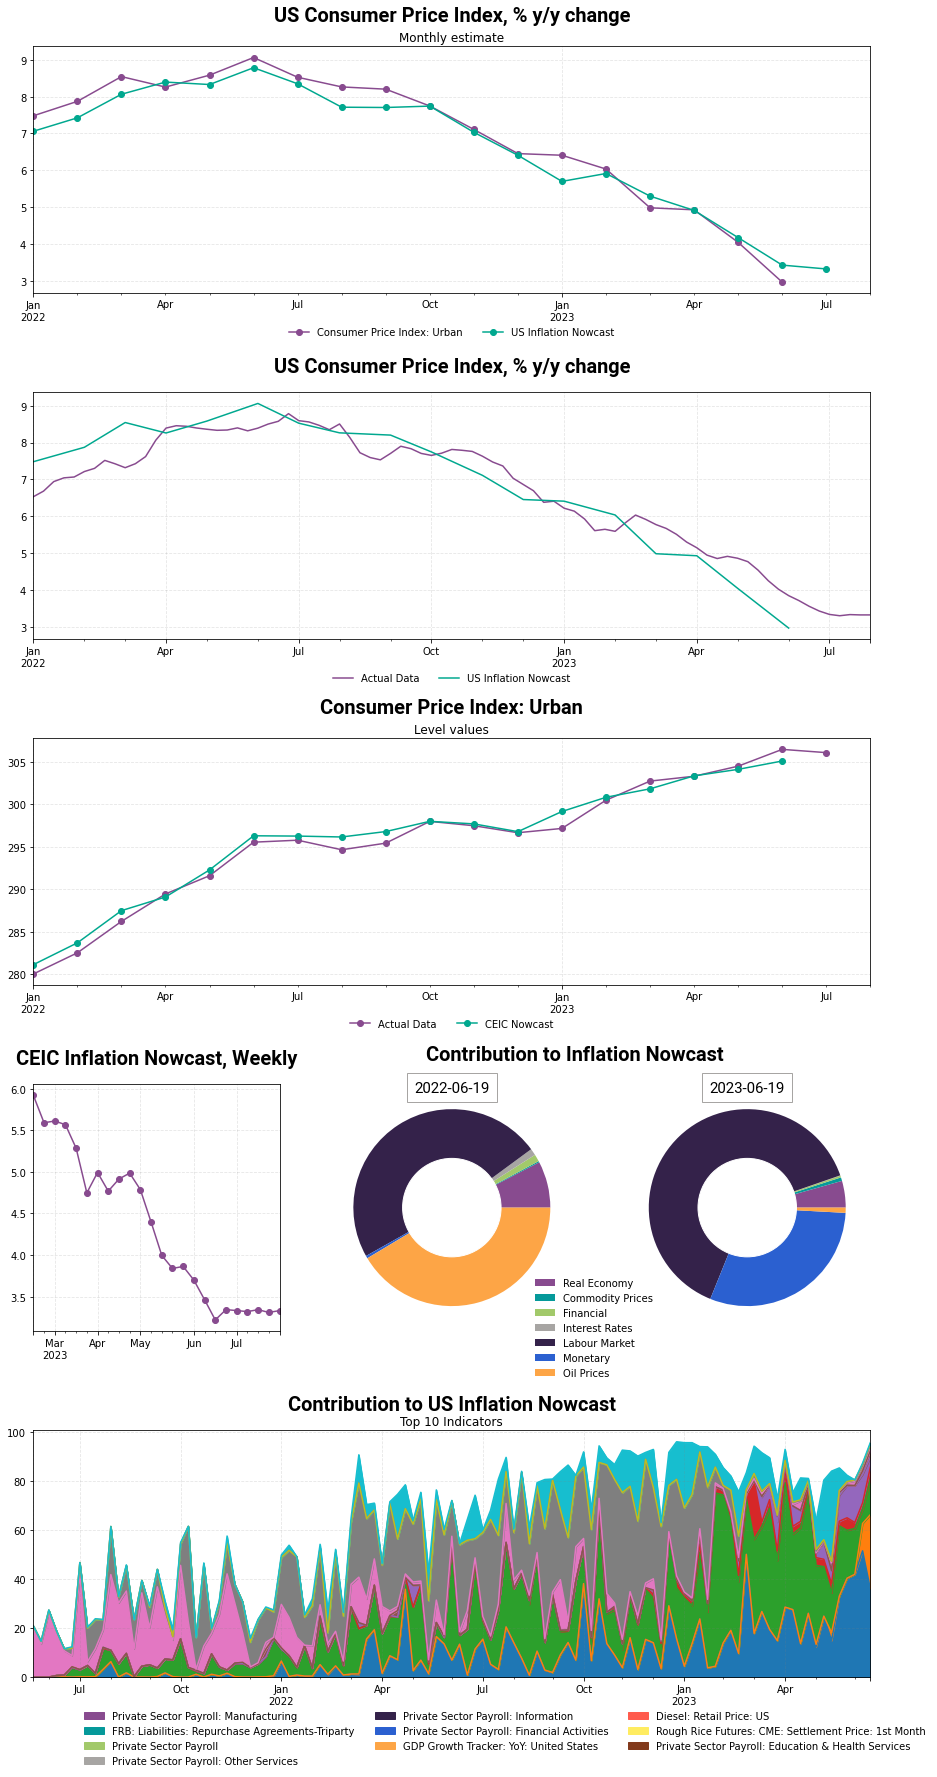

In [5]:
draw_chart()